# Контрольная работа #1
В этой контрольной работе разрешается пользоваться пакетом `cvxpy`, линейной алгеброй из `numpy/scipy`, но не `sklearn`.
## Задача #1 (2б): проекция на линейное подпространство
Дана невырожденная матрица $A\in\mathbb{R}^{m\times n}$, $m<n$, вектор $b\in \mathbb{R}^{m}$ и точка $y\in\mathbb{R}^n$. Требуется найти точку $x$ такую, что $Ax=b$ и при этом $\|x-y\|$ принимает минильное значение.

In [1]:
import numpy as np
import scipy as sc
import scipy.linalg
import cvxpy as cp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [93]:
def linear_subspace_projection(A, b, y):
    """
    Возвращает точку x: Ax=b, ||x-y||->min
    
    Args:
        A: ndarray(m, n)
        b: ndarray(m, 1)
        y: ndarray(n, 1)
        
    Returns:
        x: ndarray(n, 1)
    """
    x = cp.Variable(y.shape)
    constraints = [A @ x == b]
    obj = cp.Minimize(cp.norm(x - y))
    prob = cp.Problem(obj, constraints)
    prob.solve()
    return x.value

In [94]:
def show_projection():
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
        
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
        
    A = np.random.rand(1, 2)
    b = 0.5
    
    y = np.random.rand(2, 1)
    
    x = linear_subspace_projection(A, b, y)
    ax.scatter([y[0], x[0]], [y[1], x[1]], color='black')
    ax.plot([y[0], x[0]], [y[1], x[1]], color='grey', linestyle='--')
    ax.text(x[0] - 0.1, x[1] - 0.1, 'x', fontsize = 15)
    ax.text(y[0] + 0.1, y[1] + 0.1, 'y', fontsize = 15)
    delta = 0.05
    p = np.arange(-1.5, 1.5, delta)
    q = np.arange(-1.5, 1.5, delta)
    X, Y = np.meshgrid(p, q)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i][j] = A @ np.array([X[i][j], Y[i][j]])
    CS = ax.contour(X, Y, Z, [b], colors=['blue'])
    plt.close(fig)
    return fig

[[0.71655547 0.20181444]] 0.5 [[0.80171511]
 [0.493592  ]]


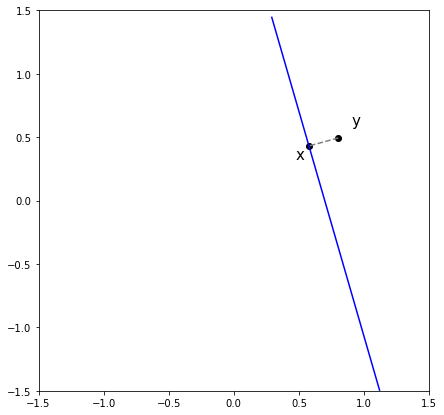

In [92]:
show_projection()

## Задача #2 (4б): логистическая регрессия
В этой задаче вам предлагается обучить модель линейной регрессии: дан набор точек $x_i\in \mathbb{R}^n$ и соответствующих им меток $y_i\in \{0, 1\}$. Нужно найти гиперплоскость как можно лучше разделяющую точки с метками $0$ от точек с метками $1$. В логистической регрессии обучается модель-предиктор:
$$
f(x, \theta)=\sigma (\theta^Tx)
$$
где
$$
\sigma(t)=\frac{1}{1+e^{-t}}.
$$
$\theta$ соответствует параметрам гиперплоскости, вдоль которой идет разделение. Величина $f(x, \theta)$ трактуется как вероятность принадлежности к классу с меткой $1$. Критерий максимального правдоподобия в данном случае эквивалентен минимизации кросс-энтропии
$$
\mathcal{J}(x, y, \theta)=-\frac{1}{m}\sum_{i=1}^m\left[y_i\log f(x_i, \theta)+(1-y_i)(1-\log(1-f(x_i, \theta)))\right]
$$
Стоит отметить, что
$$
\begin{array}{rl}
\frac{d}{dt}\sigma(t)&=\left(\frac{1}{1+e^{-t}}\right)'\\
&=-\frac{-e^{-t}}{(1+e^{-t})^2}\\
&=(1-\sigma(t))\sigma(t)
\end{array}
$$
и, соответственно
$$
\begin{array}{rl}
\nabla_\theta\mathcal{J}(x, y, \theta)&=-\frac{1}{m}\sum_{i=1}^m\left[y_i\frac{1}{\sigma(\theta^Tx_i)}(1-\sigma(\theta^Tx_i))\sigma(\theta^Tx_i)x_i-(1-y_i)\frac{1}{1-\sigma(\theta^Tx_i)}(1-\sigma(\theta^Tx_i))\sigma(\theta^Tx_i)x_i\right]\\
&=-\frac{1}{m}\sum_{i=1}^m\left[y_i(1-\sigma(\theta^Tx_i))x_i-(1-y_i)\sigma(\theta^Tx_i)x_i\right]\\
&=-\frac{1}{m}\sum_{i=1}^m\left[(y_i-\sigma(\theta^Tx_i))x_i\right]
\end{array}
$$
Реулизуйте обучение логистической регрессии с помощью градиентного спуска для смещенной логистической регрессии, т.е. для
$$
f(x, \theta, \beta)=\sigma(\theta^Tx+\beta)
$$

In [66]:
def logistic_regression(x, y, alpha, iters):
    
    def sigma(t):
        return 1 / (1 + np.exp(-t))
    
    """
    Возвращает оптимальные параметры логистической регрессии theta, beta, полученные минимизацией кросс-энтропии
    
    Args:
        x: ndarray(m, n) -- матрица, каждая строка которой является точкой, которые отделяются регрессией
        y: ndarray(m)    -- вектор-столбец, i-ый элемент которого соответствует метке i-ой строке в x,
                            принимает значения 0 или 1
        alpha: float -- размер шага для градиентного спуска
        iters: int   -- количество итераций градиентного спуска
    Returns:
        theta: ndarray(n)
        beta: float/ndarray(1) -- параметры регрессии
    """
    m = y.size
    x = np.hstack((x, np.ones((m, 1))))
    theta = np.ones(x.shape[1]) / 2
    for _ in range(iters):
        df = np.zeros_like(theta)
        for i in range(m):
            df += -alpha / m * (y[i] - sigma(theta.T @ x[i])) * x[i]
        theta -= df
    return (theta[:-1], theta[-1])

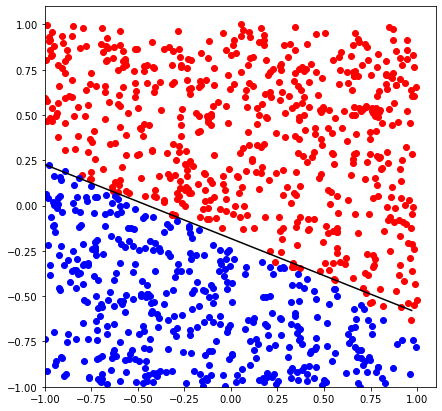

In [68]:
fig, ax = plt.subplots(figsize=[7, 7])
n = 2
m = 1000
x = 2 * np.random.rand(m, n) - 1
a = np.random.rand(n)
b = 0.2

y = (np.sign(x @ a + np.ones(m) * b) + 1) / 2

theta, beta = logistic_regression(x, y, 0.05, 1000)

ax.scatter(x[y > 0,0], x[y > 0,1], color='red')
ax.scatter(x[y == 0,0], x[y == 0,1], color='blue')
#Level contours
delta = 0.025
x_ = np.arange(-1, 1, delta)
y_ = np.arange(-1, 1, delta)
X, Y = np.meshgrid(x_, y_)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i][j] = theta @ np.array([X[i][j], Y[i][j]]) + beta
        
CS = ax.contour(X, Y, Z, [0], colors=['black'])
plt.close(fig)
fig

## Задача #3 (3б): Матричная игра
Играют два игрока, у первого есть $n$ вариантов хода, у второго -- $m$. Дана матрица игры $A$, $A_{ij}$ соответствует сумме, которую первый игрок платит второму если первый выбрал $i$ вариант действий, а второй -- $j$-ый. Требуется оптимальные смешанные стратегии для обоих игроков и цену игры, т.е. такие вектора $p:*\in \mathbb{R}^n, q:*\in \mathbb{R}^m$ с неотрицательными компонентами, суммирующимеся в $1$, что для любых других таких $p, q$ выполняется
$$
p^TAq^*\geq p^{*T}Aq^*\geq p^{*T}Aq
$$

In [110]:
def solve_mg(A):
    """
    Возвращает цену игры и оптимальные стратегии обоих игроков
    
    Args:
        A: ndarray(n, m) -- матрица игры

    Returns:
        value, p, q -- цена игры и оптимальные стратегии
        
    """
    n = A.shape[0]
    m = A.shape[1]
    p = cp.Variable(n)
    obj_p = cp.Minimize(cp.atoms.max(p.T @ A))
    constraints_p = [p >= 0, np.ones(n) @ p == 1]
    prob_p = cp.Problem(obj_p, constraints_p)
    prob_p.solve()
    
    q = cp.Variable(m)
    obj_q = cp.Maximize(cp.atoms.min(A @ q))
    constraints_q = [q >= 0, np.ones(m) @ q == 1]
    prob_q = cp.Problem(obj_q, constraints_q)
    prob_q.solve()
    return (p.value).T @ A @ q.value, p.value, q.value

In [112]:
# from two points defines the coefficients a, b, c such that a line ax+by=c goes through these points 
A = np.array([
    [1, 2, 3],
    [3, 2, 0],
    [1, 3, 1]
])

value, p_opt, q_opt = solve_mg(A)

OK = "OK" if abs(value - 2) < 1e-2 else "NOT OK"
print(f"{value} = 2  {OK}")
OK = "OK" if abs(value - p_opt @ A @ q_opt) < 1e-2 else "NOT OK"
print(f"{value} = {p_opt @ A @ q_opt}  {OK}")
OK = "OK" if value < np.array([0, 0, 1]) @ A @ q_opt else "NOT OK"
print(f"{value} < {np.array([0, 0, 1]) @ A @ q_opt}  {OK}")
OK = "OK" if value > p_opt @ A @ np.array([0, 0, 1]) else "NOT OK"
print(f"{value} > {p_opt @ A @ np.array([0, 0, 1])}  {OK}")

2.000000000105381 = 2  OK
2.000000000105381 = 2.000000000105381  OK
2.000000000105381 < 2.9999999999888285  OK
2.000000000105381 > 1.732549511755722  OK


## Задача #4 (3б): Самая верхняя точка многоугольника
Задан многоугольник в виде нескольких неравенств вида
$$
a_ix+b_iy\leq c_i
$$
Требуется найти точку с максимальной $y$ коррдинатой, удовлетворяющей всем этим неравенствам

In [97]:
def topmost_point(a, b, c):
    """
    Вычислеяет точку с максимальной y координатой
    
    Args:
        a, b, c: np.ndarray(n) -- набор неравенств вида a[i] * x + b[i] * y <= c[i]
        
    Returns:
        x, y -- координаты точки с максимальной y
    """
    z = cp.Variable(2)
    constraints = []
    for i in range(a.size):
        v = np.array([a[i], b[i]])
        constraints.append(v @ z - c[i] <= 0)
    u = np.array([[0, 1]])
    obj = cp.Maximize(u @ z)
    prob = cp.Problem(obj, constraints)
    prob.solve()
    return z.value

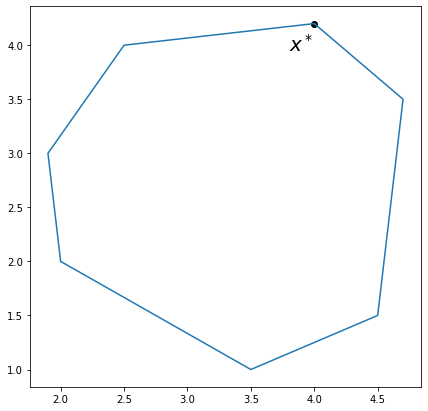

In [98]:
def get_line(x1, x2):
    a = x1[1] - x2[1]
    b = x2[0] - x1[0]
    c = a * x1[0] + b * x1[1]
    return a, b, c

vertices = [(2.0, 2.0), (1.9, 3.0), (2.5, 4.0), (4.0, 4.2), (4.7, 3.5), (4.5, 1.5), (3.5, 1.0), (2.0, 2.0)]
a = []
b = []
c = []
fig, ax = plt.subplots(figsize=(7, 7))

for i in range(len(vertices) - 1):
    a_, b_, c_ = get_line(vertices[i], vertices[i + 1])
    a.append(a_)
    b.append(b_)
    c.append(c_)
    #print(f'{float(a):6.2} * x + {float(b):4.2} * y <= {float(a):4.2}')
a = np.array(a)
b = np.array(b)
c = np.array(c)
x = topmost_point(a, b, c)
ax.plot([x for x, y in vertices], [y for x, y in vertices])
ax.scatter([x[0]], [x[1]], color='black')
#ax.arrow(x[0], x[1], direction[0] * 0.3, direction[1] * 0.3, head_width=0.07, overhang=0.5)
#ax.text(x[0] + direction[0] * 0.15 - 0.1, x[1] + direction[0] * 0.15 + 0.2, '$c$', fontsize=20)
ax.text(x[0] - 0.2, x[1] - 0.25, '$x^*$', fontsize=20)

plt.close(fig)
fig